In [1]:
# 1) Install NLP Libraries
# Run this in terminal first:
!pip install nltk scikit-learn pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load SMS Spam Collection Dataset
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')[['v1','v2']]
    df.columns = ['label','text']
    print("✅ Dataset loaded successfully!")
except:
    print("📥 Download dataset from: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")
    # Alternative: Create sample data for demonstration
    sample_data = {
        'label': ['ham', 'spam', 'ham', 'spam', 'ham'],
        'text': [
            'Free entry in 2 a wkly comp to win FA Cup final',
            'Nah I don think he goes to usf, he lives around here though',
            'Even my brother is not like to speak with me. They treat me like aids patent.',
            'FreeMsg Hey there darling it has been 3 weeks now and no word back!',
            'As per your request Melle Melle (Oru Minninaminute) has been set as your callertune'
        ]
    }
    df = pd.DataFrame(sample_data)
    print("📋 Using sample data for demonstration")

print("\n📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Label distribution:\n{df['label'].value_counts()}")

✅ Dataset loaded successfully!

📊 Dataset Info:
Shape: (5572, 2)
Columns: ['label', 'text']
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


In [9]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


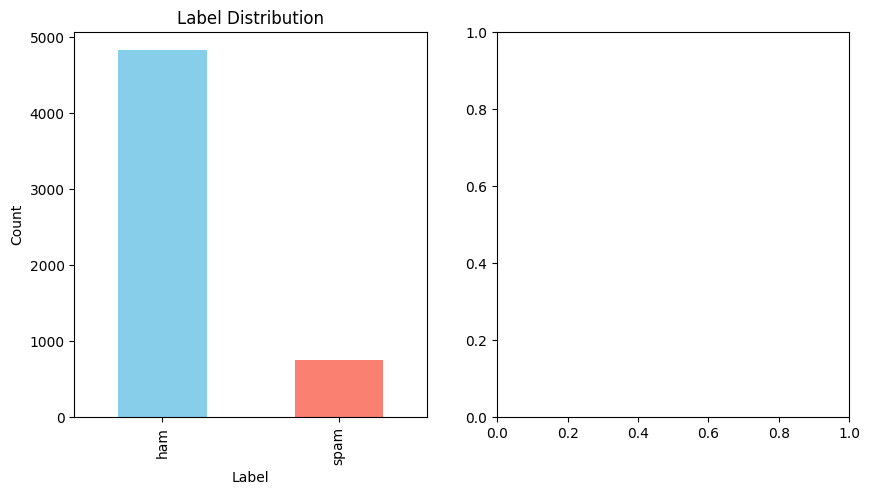

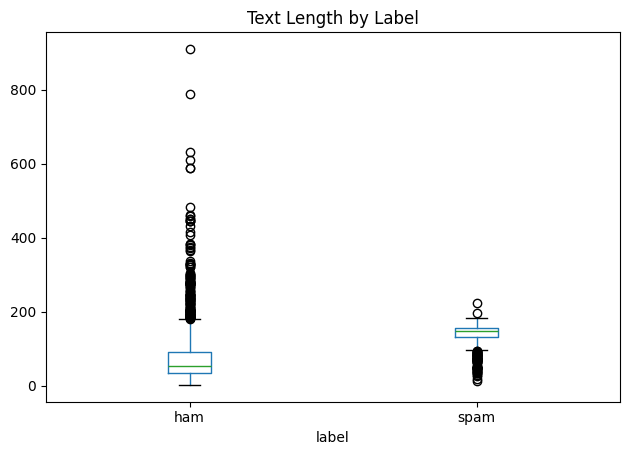

In [11]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['text_length'] = df['text'].apply(len)
df.boxplot(column='text_length', by='label', grid=False)
plt.title('Text Length by Label')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [13]:
# 3) Preprocess Text
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download required NLTK resources
print("📥 Downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print("✅ NLTK resources downloaded!")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to wordnet POS tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    """
    Comprehensive text preprocessing pipeline:
    1. Lowercasing
    2. Remove special characters and numbers
    3. Tokenization
    4. POS tagging
    5. Stopword removal
    6. Lemmatization
    """
    try:
        # 1. Lowercasing
        text = text.lower()
        
        # 2. Remove special characters and numbers (keep only letters)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # 3. Tokenization
        tokens = word_tokenize(text)
        
        # 4. POS tagging for better lemmatization
        pos_tags = nltk.pos_tag(tokens)
        
        # 5. Stopword removal and lemmatization
        processed_tokens = []
        for word, pos in pos_tags:
            if word not in stop_words and len(word) > 2:  # Remove short words
                wordnet_pos = get_wordnet_pos(pos)
                lemma = lemmatizer.lemmatize(word, wordnet_pos)
                processed_tokens.append(lemma)
        
        return ' '.join(processed_tokens)
    
    except Exception as e:
        print(f"Error processing text: {text[:50]}... Error: {e}")
        return ""

print("🔄 Preprocessing text data...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

📥 Downloading NLTK resources...
✅ NLTK resources downloaded!
🔄 Preprocessing text data...


In [15]:
# Visualize most common words
from collections import Counter

def plot_common_words(text_series, title, top_n=20):
    """Plot most common words"""
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    
    common_words = word_freq.most_common(top_n)
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f'Top {top_n} Most Common Words - {title}')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

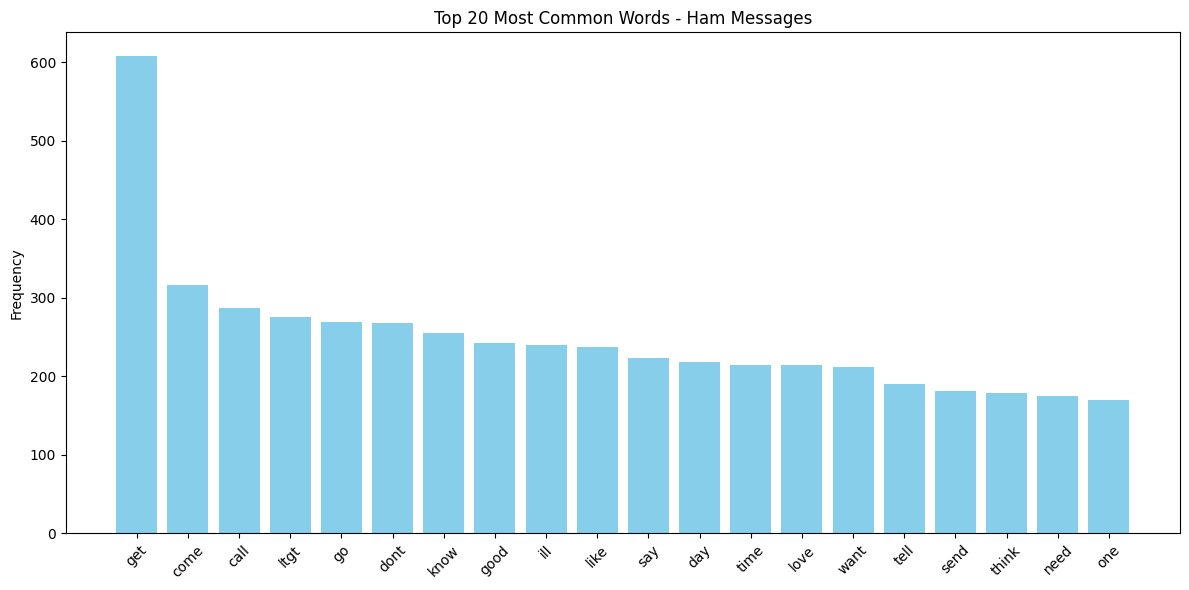

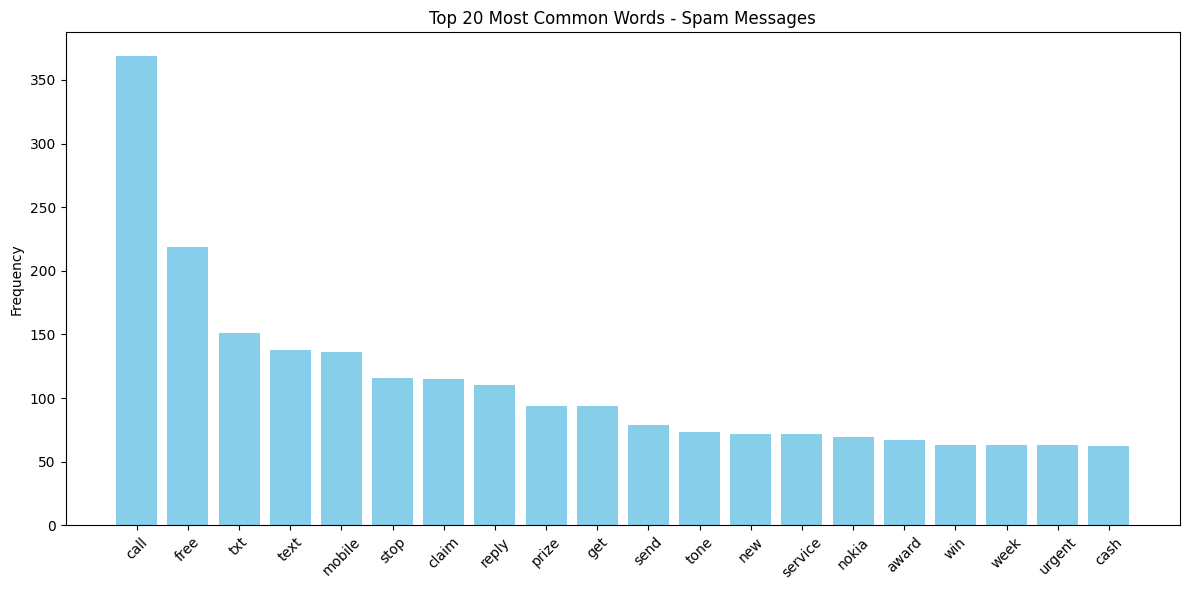

In [17]:
# Plot for ham messages
ham_texts = df[df['label'] == 'ham']['cleaned_text']
spam_texts = df[df['label'] == 'spam']['cleaned_text']

plot_common_words(ham_texts, 'Ham Messages')
plot_common_words(spam_texts, 'Spam Messages')


🔢 Converting text to vectors...
✅ Vectorization completed!
Count vectors shape: (5572, 3000)
TF-IDF vectors shape: (5572, 3000)

📝 Sample feature names: ['aah' 'aathilove' 'abi' 'abiola' 'able' 'abt' 'abta' 'acc' 'accept'
 'access' 'accidentally' 'account' 'account statement' 'ache' 'act'
 'action' 'activate' 'activity' 'actually' 'add']


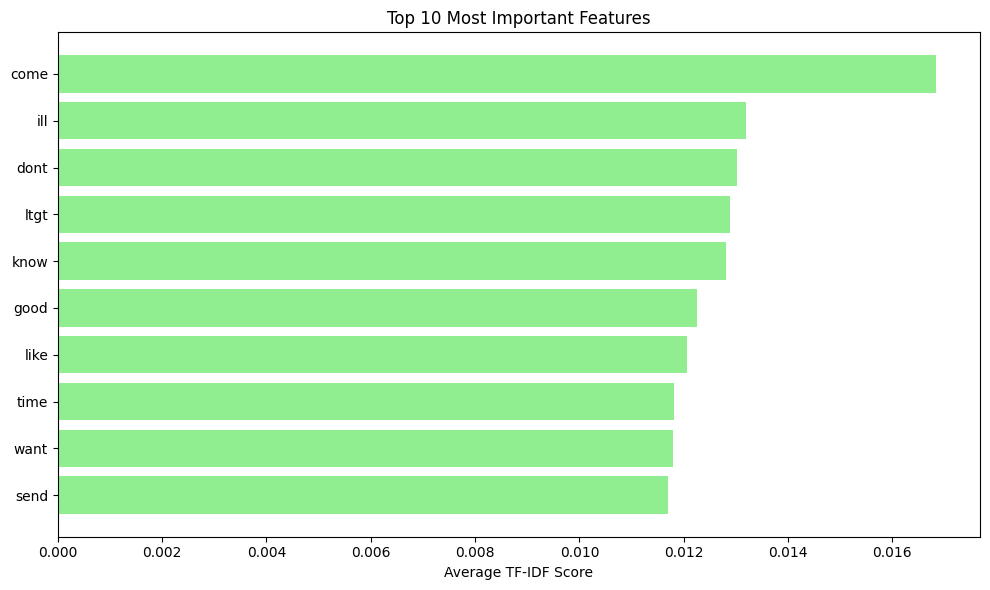

In [19]:
#  4) Convert to Vectors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

print("🔢 Converting text to vectors...")

# Method 1: Count Vectorization
count_vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 2))
X_count = count_vectorizer.fit_transform(df['cleaned_text'])

# Method 2: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000, 
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print(f"✅ Vectorization completed!")
print(f"Count vectors shape: {X_count.shape}")
print(f"TF-IDF vectors shape: {X_tfidf.shape}")

# Show feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n📝 Sample feature names: {feature_names[:20]}")

# Visualize vectorization
def visualize_vectorization(vectorizer, X, n_features=10):
    """Visualize the vectorization process"""
    feature_names = vectorizer.get_feature_names_out()
    
    # Get document with highest average TF-IDF score
    doc_scores = X.mean(axis=0).A1
    top_indices = doc_scores.argsort()[-n_features:][::-1]
    
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [doc_scores[i] for i in top_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_scores, color='lightgreen')
    plt.xlabel('Average TF-IDF Score')
    plt.title(f'Top {n_features} Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

visualize_vectorization(tfidf_vectorizer, X_tfidf)

In [21]:
#5) Train Classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Prepare data
X = X_tfidf  # Using TF-IDF features
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("📊 Training Data Info:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")


📊 Training Data Info:
Training set size: 4457
Test set size: 1115
Feature dimension: 3000


In [23]:
# Train multiple classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Multinomial NB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, classifier in classifiers.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"✅ {name} Accuracy: {accuracy:.4f}")




🔄 Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.9587

🔄 Training Multinomial NB...
✅ Multinomial NB Accuracy: 0.9668

🔄 Training Random Forest...
✅ Random Forest Accuracy: 0.9776



🏆 Best Model: Random Forest
📈 Accuracy: 0.9776

📋 Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



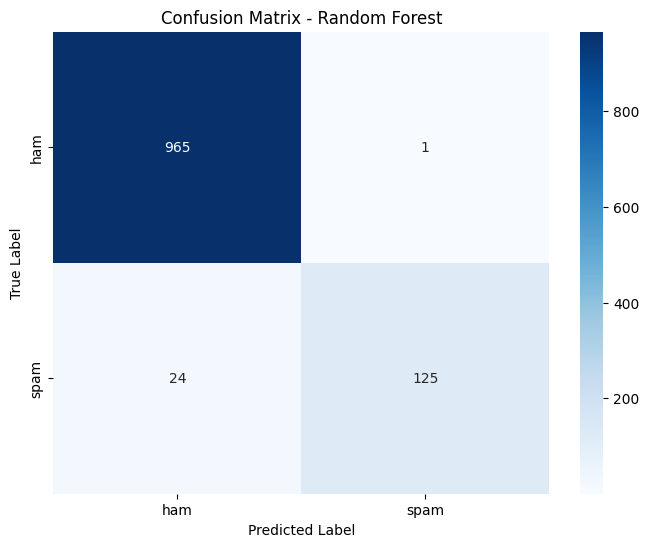

In [25]:
# Detailed evaluation for best model
best_model_name = max(results, key=results.get)
best_model = classifiers[best_model_name]
y_pred = best_model.predict(X_test)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"📈 Accuracy: {results[best_model_name]:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [27]:
# Feature Importance (for Logistic Regression)
if best_model_name == 'Logistic Regression':
    print("\n🔍 Top 10 Most Important Features for Spam Classification:")
    feature_importance = best_model.coef_[0]
    top_indices = feature_importance.argsort()[-10:][::-1]
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")



In [29]:
# Test the model with new examples
def predict_spam(text, model, vectorizer, label_encoder):
    """Predict if a text is spam or ham"""
    # Preprocess the text
    cleaned_text = preprocess_text(text)
    
    # Vectorize
    text_vector = vectorizer.transform([cleaned_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]
    
    # Decode label
    label = label_encoder.inverse_transform([prediction])[0]
    
    return label, probability

# Test examples
test_examples = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account needs verification. Click link to secure your account.",
    "Thanks for your email. I'll get back to you soon."
]

print("\n🧪 Testing Model with Examples:")
for example in test_examples:
    label, prob = predict_spam(example, best_model, tfidf_vectorizer, label_encoder)
    print(f"\n📝 Text: {example}")
    print(f"🔮 Prediction: {label} (Probability: {max(prob):.4f})")



🧪 Testing Model with Examples:

📝 Text: Congratulations! You've won a $1000 Walmart gift card. Click here to claim now!
🔮 Prediction: spam (Probability: 0.7409)

📝 Text: Hey, are we still meeting for lunch tomorrow?
🔮 Prediction: ham (Probability: 1.0000)

📝 Text: URGENT: Your bank account needs verification. Click link to secure your account.
🔮 Prediction: spam (Probability: 0.5100)

📝 Text: Thanks for your email. I'll get back to you soon.
🔮 Prediction: ham (Probability: 1.0000)


In [31]:
# Save the model and vectorizer
import joblib

model_artifacts = {
    'model': best_model,
    'vectorizer': tfidf_vectorizer,
    'label_encoder': label_encoder,
    'preprocessing_function': preprocess_text
}

joblib.dump(model_artifacts, 'spam_classifier_model.pkl')
print("💾 Model artifacts saved as 'spam_classifier_model.pkl'")

💾 Model artifacts saved as 'spam_classifier_model.pkl'
